In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.text import *

## Creating the DataBunch for the language model

In [3]:
data_lm = TextLMDataBunch.from_csv('.','normas.csv',delimiter='|',text_cols='textos',label_cols='macrotemas')
data_lm.save('data_lm')

In [4]:
data_lm.show_batch()

idx,text
0,"2 ° , do art . 55 do xxmaj regimento xxmaj interno da xxup anvisa , aprovado nos termos do xxmaj anexo i da xxmaj portaria nº 354 da xxup anvisa , de 11 de agosto de 2006 , republicada no xxup dou de 21 de agosto de 2006 , e a xxmaj portaria n ° 1017 , de 5 de dezembro de 2007 , \n considerando o disposto"
1,"o controle das áreas de estoque de componentes , materiais de fabricação e produtos acabados para evitar inversões ( trocas ) , danos , deteriorização ou outros efeitos adversos no período anterior à sua distribuição ou uso . \n ( b ) xxmaj cada fabricante deverá estabelecer e manter procedimentos para autorizar o recebimento ou retirada das áreas de estoque . xxmaj qualquer controle numérico ou outra forma de"
2,"% ( p / v ) em clorofórmio . xxmaj observar à luz ultravioleta de onda longa ( 365 xxunk ) . xxmaj serão observadas duas manchas com xxmaj rf próximos , respectivamente , a 0,22 e xxunk . \n xxmaj conservação \n xxmaj em frasco de vidro neutro , âmbar , hermeticamente fechado , ao abrigo da luz e do calor . \n xxmaj forma derivada"
3,"ficam também sob controle todos os sais e isômeros das substâncias enumeradas acima , sempre que seja possível a sua existência . \n 2 ) fica autorizado o uso de xxup lindano como padrão analítico para fins laboratoriais ou monitoramento de resíduos ambientais , conforme legislação específica . xxbos xxup resolução xxup de xxup diretoria xxup colegiada - xxup rdc xxmaj nº 18 , xxup de 12 xxup de"
4,"reprografia , manutenção da infraestrutura física , mensageria , emissão de passagens aéreas , aquisição de bens de consumo e bens permanentes , atividades gerais de administração e engenharia , de responsabilidade da xxmaj agência , no âmbito do xxmaj distrito xxmaj federal ; \n xxup iii – propor procedimentos relativos à gestão de atividades e serviços de logística da xxmaj anvisa no âmbito do xxmaj distrito xxmaj federal"


## Training the Language Model

In [4]:
learn_lm = language_model_learner(data_lm, AWD_LSTM, drop_mult = 0.5, pretrained=False, callback_fns=ShowGraph)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


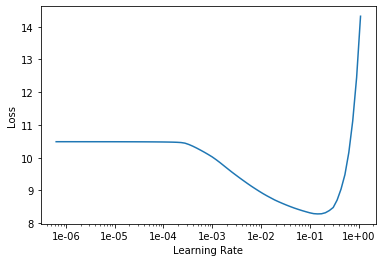

In [6]:
learn_lm.lr_find()
learn_lm.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
0,3.753799,3.664731,0.381841,03:20
1,2.628968,2.870552,0.472012,03:20
2,2.427556,2.644896,0.495405,03:20
3,2.475480,2.621188,0.494432,03:20
4,2.475948,2.594481,0.496488,03:20
5,2.397542,2.551999,0.503365,03:20
6,2.436933,2.485989,0.511909,03:20
7,2.263047,2.437244,0.520211,03:20
8,2.231137,2.350238,0.533918,03:20
9,2.062670,2.278222,0.546588,03:20


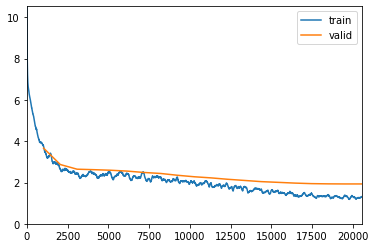

Better model found at epoch 0 with accuracy value: 0.3818407356739044.
Better model found at epoch 1 with accuracy value: 0.4720115065574646.
Better model found at epoch 2 with accuracy value: 0.4954052269458771.
Better model found at epoch 4 with accuracy value: 0.4964875280857086.
Better model found at epoch 5 with accuracy value: 0.5033648610115051.
Better model found at epoch 6 with accuracy value: 0.5119093656539917.
Better model found at epoch 7 with accuracy value: 0.5202112793922424.
Better model found at epoch 8 with accuracy value: 0.5339184403419495.
Better model found at epoch 9 with accuracy value: 0.5465880036354065.
Better model found at epoch 10 with accuracy value: 0.5545252561569214.
Better model found at epoch 11 with accuracy value: 0.566081166267395.
Better model found at epoch 12 with accuracy value: 0.5766850113868713.
Better model found at epoch 13 with accuracy value: 0.5882808566093445.
Better model found at epoch 14 with accuracy value: 0.5962914228439331.
Be

In [5]:
max_lr = 1e-2
learn_lm.fit_one_cycle(20, max_lr=max_lr, moms=(0.8,0.7), callbacks=[callbacks.SaveModelCallback(learn_lm, every='improvement', monitor='accuracy', name='learn_lm')])

In [6]:
#Load the best version of the language model
learn_lm.load('learn_lm')
learn_lm.save_encoder('enc')

In [7]:
#Seeing what kind of text it generates
print(learn_lm.predict('Art. 1º Esta resolução visa',n_words=200,temperature=0.8))

Art. 1º Esta resolução visa ser tendo em vista os riscos oferecidos à saúde humana e ao meio ambiente decorrentes da alteração da finalidade a que se destina , conforme Anexo II desta Resolução . Esta Resolução se aplica a todos os produtos sujeitos à vigilância sanitária , inclusive aqueles destinados exclusivamente à exportação e aos produtos abrangidos por este regulamento . 
 
  Art . 2º As empresas têm o prazo de 180 ( cento e oitenta ) dias , a contar da data da publicação deste Regulamento , para se adequarem ao mesmo . 
  Art . 3º Esta Resolução entra em vigor na data de sua publicação e revogam - se as disposições em contrário . 
  GONZALO VECINA NETO xxbos RESOLUÇÃO DA DIRETORIA COLEGIADA – RDC Nº 44 , DE 18 DE AGOSTO DE 2007 
  ( Publicada no DOU nº 184 , de 23 de setembro de 2009 ) 
  ( Revogada pela Resolução – RDC nº 23 , de 20 de maio de 2009 ) 
  Dispõe sobre o


## Now, extracting the vector representation of the texts

In [3]:
#loading de list with all the texts that I want to get the representation
normas = list(pd.read_csv('normas_vigentes.csv',sep='|',encoding='utf-8')['textos'])

In [4]:
data_lm = load_data('.',file='data_lm')
learn_lm = language_model_learner(data_lm, AWD_LSTM, drop_mult = 0.5, pretrained=False, callback_fns=ShowGraph)
learn_lm.load('learn_lm')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (9228 items)
x: LMTextList
xxbos o xxmaj para efeito desta xxmaj resolução são adotadas as seguintes definições :,xxbos o xxmaj termo de xxmaj consentimento xxmaj livre e xxmaj esclarecido deve ser redigido em linguagem clara e compreensível e deve conter , quando couber :,xxbos . xxmaj os desinfetantes e detergentes devem ter sua eficácia comprovada e ser monitorados para detectar possível contaminação microbiana .,xxbos ° o descumprimento desta xxmaj resolução constitui infração sanitária sujeitando os infratores as penalidades da xxmaj lei n ° 6.437 , de 20 de agosto de 1977 e demais disposições aplicáveis ;,xxbos a precisão deve ser expressa por meio da repetibilidade , da precisão intermediária ou da reprodutibilidade .
y: LMLabelList
,,,,
Path: .;

Valid: LabelList (2308 items)
x: LMTextList
xxbos xxmaj as petições de certificação que não estiverem xxunk com a documentação exigida quando do seu pr

In [10]:
#Here I get the vector representation of the text using the trained encoder
mbe = MultiBatchEncoder(70,1400,learn_lm.model[0])

def masked_concat_pool(outputs, mask):
    "Pool MultiBatchEncoder outputs into one vector [last_hidden, max_pool, avg_pool]."
    output = outputs[-1]
    avg_pool = output.masked_fill(mask[:, :, None], 0).mean(dim=1)
    avg_pool *= output.size(1) / (output.size(1)-mask.type(avg_pool.dtype).sum(dim=1))[:,None]
    max_pool = output.masked_fill(mask[:,:,None], -float('inf')).max(dim=1)[0]
    x = torch.cat([output[:,-1], max_pool, avg_pool], 1)
    return x

X = np.zeros((1,1200))
i=0
for norma in normas:
    xb,yb = learn_lm.data.one_item(norma)
    sentence = torch.cuda.LongTensor(xb.tolist()[0]).unsqueeze(0)
    raw_outputs, outputs, masks = mbe.forward(sentence)
    sentence_rep = masked_concat_pool(outputs, masks)
    X = np.append(X,sentence_rep,axis=0)
    if len(normas) % (i+1) == 10: print(str(i+1) + ' out of ' + str(len(normas)))
    i+=1

107 out of 866
214 out of 866
428 out of 866
856 out of 866


In [12]:
#the first row is the initialized as zeros, i dont need it
X = np.delete(X, (0), axis=0)

In [13]:
#save the texts repesentation in a file
np.save('X_LM', X)